In [1]:
# from tqdm import tqdm
import numpy as np
import scipy.linalg
import pickle as pkl
import time
import sys
import os
import copy
import torch
import scipy.io
# from attrdict import AttrDict
import argparse
from torch.utils.data import DataLoader
import torch.nn as nn

from torch.autograd import Variable
from torch.nn.parameter import Parameter

import torchvision.transforms as T
import torch.nn.functional as F
from torch.distributions import Gamma

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors
from scipy import array, linalg, dot
import math
from scipy.io import savemat, loadmat
# import matplotlib.backends.backend_pdf
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rcParams['text.usetex'] = True
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle as pk

from multiprocessing import Pool
import multiprocessing
# from my_model import mymf
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import pickle as pk
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import shutil
from IPython.display import clear_output
from time import sleep
import h5py
# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
from flopy.utils.util_array import read1d
mpl.rcParams['figure.figsize'] = (8, 8)
from TCP3d_model import mymf
from para_simu import simu
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))
exe_name_mf = '/Users/zitongzhou/Downloads/pymake/examples/mf2005'
exe_name_mt = '/Users/zitongzhou/Downloads/pymake/examples/mt3dms'


3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.19.2
matplotlib version: 3.3.1
flopy version: 3.3.2


In [3]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    eps = torch.randn_like(std)
    #randn_like: Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
    #return: random gaussian sample from distribution with mu and exp(logvar/2)
    return mu + eps*std

class DenseResidualBlock(nn.Module):
    """
    The core module of paper: (Residual Dense Network for Image Super-Resolution, CVPR 18)
    """

    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        def block(in_features, non_linearity=True):
            layers = [nn.BatchNorm3d(in_features)]
            layers += [nn.ReLU(inplace=True)]
            layers += [nn.Conv3d(in_features, filters, 3, 1, 1, bias=True)] # does not change state size
            return nn.Sequential(*layers)

        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters, non_linearity=False)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)
        return out.mul(self.res_scale) + x


class ResidualInResidualDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), DenseResidualBlock(filters), DenseResidualBlock(filters)#, DenseResidualBlock(filters)
        )

    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x

class Encoder(nn.Module):
    def __init__(self, inchannels=1, outchannels=2, filters=48, num_res_blocks=1):
        super(Encoder, self).__init__()
        # input size, inchannels x 6 x 41 x 81
        self.conv1 = nn.Conv3d(inchannels, filters, kernel_size=3, stride=2, padding=1)
        # state size. filters x 3 x 21 x 41
        self.res_blocks = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        # state size. filters x 3 x 21 x 41
        self.trans = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Conv3d(filters, filters, kernel_size=3, stride=2, padding=1),
        )
        # state size. filters x 2 x 11 x 21
        self.mu = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.
        self.logvar = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.

    def forward(self, img):
        # img: inchannels x 6 x 41 x 81
        out1 = self.conv1(img)        # filters x 3 x 21 x 41
        out2 = self.res_blocks(out1)   # filters x 3 x 21 x 41
        out3 = self.trans(out2)        # filters x 2 x 11 x 21

        mu, logvar = self.mu(out3), self.logvar(out3)
        z = reparameterization(mu, logvar) # latent dimension: outchannels x 2 x 11 x 21
        return z

    def _n_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params
                
class Decoder(nn.Module):
    def __init__(self, inchannels=2, outchannels=1, filters=48, num_res_blocks=1,num_upsample=2):
        super(Decoder, self).__init__()

        # First layer. input size, inchannels x 2 x 8 x 16
        self.conv1 = nn.Conv3d(inchannels, filters, kernel_size=3, stride=1, padding=1)

        # state size. filters x 2 x 8 x 16
        # Residual blocks
        self.res_block1 = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks+1)])
        self.transup1 = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(4, 21, 41), mode='nearest'),
            nn.Conv3d(filters, filters, kernel_size=3, stride=1, padding=1), #does not change state size
        )
        self.res_block2 = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        self.transup2 = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(8, 41, 81), mode='nearest'),
            nn.Conv3d(filters, outchannels, kernel_size=3, stride=1, padding=(0,1,1)), # reduce the first dimension by 2
        )


    def forward(self, z):
        # x: in_channels x 2 x 8 x 16
        out1 = self.conv1(z)          # filters x 2 x 8 x 16
        out2 = self.res_block1(out1)   # filters x 2 x 8 x 16
        out = torch.add(out1, out2)   # filters x 2 x 8 x 16
        out3 = self.transup1(out)      # filters x 4 x 16 x 32
        out4 = self.res_block2(out3)   # filters x 4 x 16 x 32

        img = self.transup2(out4)     # outchannels x 6 x 32 x 64

        return img

    def _n_parameters(self):
        n_params= 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params
    
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.cpu().detach().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or '\
            'np.ndarray, but got {}'.format(type(input)))

In [4]:
'''Load the CAAE model first'''
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
n_train = 23000
n_test = 100
batch_size = 64
n_epochs = 50
lr = 0.0002 ## adam learning rate
lw = 0.01 ## "adversarial loss weight"

current_dir = "/Volumes/GoogleDrive/My Drive/react_inverse/CAAE/"
date = 'experiments/Feb_14_CAAE3D'
exp_dir = current_dir + date + "/N{}_Bts{}_Eps{}_lr{}_lw{}".\
    format(n_train, batch_size, n_epochs, lr, lw)

output_dir = exp_dir + "/predictions"
model_dir = exp_dir

nf, d, h, w = 2, 2, 11, 21

# Initialize encoder
# encoder = Encoder(outchannels=nf)
# encoder.load_state_dict(torch.load(model_dir + '/AAE_encoder_epoch{}.pth'.format(n_epochs)))
# if cuda:
#     encoder.cuda()

# encoder.eval()

# Initialize decoder
decoder = Decoder(inchannels=nf)
decoder.load_state_dict(torch.load(model_dir + '/AAE_decoder_epoch{}.pth'.format(n_epochs), map_location=torch.device('cpu')))
if cuda:
    decoder.cuda()

decoder.eval()

def plot_3d(data, title='', cut=None):
    data = np.transpose(data, (2, 1, 0))
    data = np.flip(data, axis=2)
    filled = np.ones(data.shape)
    if cut is not None:
        filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
    x, y, z = np.indices(np.array(filled.shape) + 1)
    
    v1 = np.linspace(np.min(data),np.max(data), 8, endpoint=True)
    norm = matplotlib.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm(data)), edgecolors=None)
    ax.set_box_aspect([250, 125, 50])
    
    m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
    m.set_array([])
    fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04,ticks=v1,)
    ax.set_axis_off()
    plt.tight_layout()
    # ax.set_title(title)
    fig.savefig(title+'.pdf')
    return fig

def simple_plot(c_map, title=''):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250

    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    if len(c_map) == 41:
        fig, axs = plt.subplots(1,1)
    #        axs.set_xlabel('x(m)')
    #        axs.set_ylabel('y(m)')
        # axs.set_xlim(0,Lx)
        # axs.set_ylim(0,Ly)
        c01map = axs.imshow(c_map, cmap='jet',
                  extent=[x.min(), x.max(), y.min(), y.max()],
                  vmin=c_map.min(), vmax = c_map.max(),
                  origin='lower')
        fig.colorbar(c01map, ax=axs,shrink=0.62)
    else:
        fig, axs = plt.subplots(len(c_map)//3, 3, figsize=(7, 2.5))
        axs = axs.flat
        for i, ax in enumerate(axs):
            # ax.set_xlim(0,Lx)
            # ax.set_ylim(0,Ly)
            c01map = ax.imshow(c_map[i], cmap='jet', interpolation='nearest',
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      vmin=c_map[i].min(), vmax = c_map[i].max(),
                      origin='lower')
            ax.set_axis_off()
            v1 = np.linspace(np.min(c_map[i]),np.max(c_map[i]), 5, endpoint=True)
            fig.colorbar(c01map, ax=ax, fraction=0.021, pad=0.04,ticks=v1,)

    plt.suptitle(title)
    name = title + '.pdf'
    plt.tight_layout()
#         fig.savefig('images/'+name, format='pdf',bbox_inches='tight')
    plt.show()
    return fig

In [5]:
def ES_MDA(num_ens,m_ens,Z,prod_ens,alpha,CD,corr,numsave=2):
    # Z is the obs; prob_ens is the sim_obs; CD is the error
    # note that in this func, the shape of the array is (Num_nodes,Num_ens)
    varn=1-1/math.pow(10,numsave)
    # Initial Variavel 
    # Forecast step
    yf = m_ens.T                      # Non linear forward model, transform to (Num_nodes,Num_ens)
    df = prod_ens.T                   # Observation Model, transform to (Num_nodes,Num_ens)
    ym = np.array(yf.mean(axis=1))    # Mean of the y_f
    dm = np.array(df.mean(axis=1))    # Mean of the d_f
    ym=ym.reshape(ym.shape[0],1)    
    dm=dm.reshape(dm.shape[0],1)    
    dmf = yf - ym
    ddf = df - dm
    
    Cmd_f = (np.dot(dmf,ddf.T))/(num_ens-1);  # The cros-covariance matrix
    Cdd_f = (np.dot(ddf,ddf.T))/(num_ens-1);  # The auto covariance of predicted data
    
    # Perturb the vector of observations
    R = linalg.cholesky(CD,lower=True) #Matriz triangular inferior
    U = R.T   #Matriz R transposta
    p , ww =np.linalg.eig(CD)
    
    aux = np.repeat(Z,num_ens,axis=1)

    mean = 0*(Z.T)

    noise=np.random.multivariate_normal(mean[0], np.eye(len(Z)), num_ens).T
    d_obs = aux+math.sqrt(alpha)*np.dot(U,noise)  
    
    # Analysis step
    u, s, vh = linalg.svd(Cdd_f+alpha*CD); v = vh.T
    diagonal = s
    for i in range(len(diagonal)):
        if (sum(diagonal[0:i+1]))/(sum(diagonal)) > varn:
            diagonal = diagonal[0:i+1]
            break
    
    u=u[:,0:i+1]
    v=v[:,0:i+1]
    ss = np.diag(diagonal**(-1))
    K=np.dot(Cmd_f,(np.dot(np.dot(v,ss),(u.T))))
    # Use Kalman covariance
    if len(corr)>0:
        K = corr*K
        
    ya = yf + (np.dot(K,(d_obs-df)))
    m_ens = ya
    return m_ens.T # tranform back to (Num_ens,Num_nodes)

def vis_sensors_2(meas, data,sensor, t):
    ##meas: 11, 120
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle(t)
    for i in range(len(meas[0])):
        sen = [None]*len(meas)
        sen_obs = [None]*len(meas)
        for j in range(len(meas)-1):
            sen[j] = meas[j][i]
            sen_obs[j] = data[j][i]
        ax = fig.add_subplot(12,len(meas[0])//12,i+1)
        ax.plot(sen, 'b',label='meas')
        ax.plot(sen_obs, 'r',label='obs')
        ax.set_title(str(sensor[0][i])+','+str(sensor[1][i])+','+str(sensor[2][i]))
    ax.legend()
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    name = t + '.pdf'
#     fig.savefig(name, format='pdf')
    plt.show()

In [6]:
## parallel doesn't work well with cpu
ns = 924 + 5 + 2
Na = 1
Num_ens = 100
s=np.zeros((Num_ens, ns, Na+1))
# s[:,:,:924, 0] = np.stack([kd_init[:Num_ens,:] for _ in range(20)]) #start from the kd only ensemble
s[:,:924, 0] = np.random.randn(Num_ens, 924) #start from random ensemble 
## test 10
for i in range(10):
    start = time.time()
    kd_latent = s[:i+1, :924]
    kd_latent = Tensor(kd_latent.reshape((-1, nf, d, h, w)))
    decoder.eval()
    log_K = to_numpy(decoder(kd_latent).reshape(-1, 6, 41, 81))
    end = time.time()
    print('time of generating {} conductivity:'.format(i+1), (end-start)/(i+1))

time of generating 1 conductivity: 0.5830957889556885
time of generating 2 conductivity: 0.6225910186767578
time of generating 3 conductivity: 0.6120560963948568
time of generating 4 conductivity: 0.6212202310562134
time of generating 5 conductivity: 0.6392908096313477
time of generating 6 conductivity: 0.662233829498291
time of generating 7 conductivity: 0.6629839965275356
time of generating 8 conductivity: 0.6715970933437347
time of generating 9 conductivity: 0.6320552031199137
time of generating 10 conductivity: 0.6715306997299194


In [6]:
y_obs = np.linspace(5, 35, num=4).astype('int')
x_obs = np.linspace(20, 75, num=6).astype('int')
# x_obs = np.linspace(31, 75, num=3).astype('int')
print(x_obs)
sensor = np.zeros((6, 41, 81))
for i in range(len(y_obs)):
    for j in range(6):
        for k in range(len(x_obs)):
            sensor[j, int(y_obs[i]), int(x_obs[k])] = 1
# simple_plot(sensor, 'Most sensors')
sensor = sensor>0

[20 31 42 53 64 75]


In [7]:
with open('/Volumes/GoogleDrive/My Drive/react_inverse/ILUES/real_hk_data.pkl','rb') as file:
    [real_hk, real_conc, real_source_loc, real_source_rate, meas_data, meas_sig] = pkl.load(file)

In [8]:
ns = 924 + 5 + 2
Na = 10
Alpha=np.array([Na for _ in range(Na)])
meas_data = meas_data.reshape((-1,1))
#meas_sig
Num_obs = meas_sig.shape[0]
R=np.diag(meas_sig.reshape(-1))

Num_ens = 480
s=np.zeros((Num_ens, ns))
# s[:,:,:924, 0] = np.stack([kd_init[:Num_ens,:] for _ in range(20)]) #start from the kd only ensemble
s[:, :924] = np.random.randn(Num_ens, 924) #start from random ensemble 
s[:, 924:929] = np.stack(np.random.uniform(100, 1000, size=(Num_ens, 5)))
s[:, 929] = np.random.randint(4, 37, size=Num_ens)
s[:, 930] = np.random.randint(4, 20, size=Num_ens)

In [81]:
real_source_rate

[224.0, 174.0, 869.0, 201.0, 741.0]

In [84]:
meas_sig.shape

(1584,)

In [ ]:
problematic_conc = []
for t in range(len(Alpha)):
    ## make input files
    con_rate = []
    kds = []
    Sy_id, Sx_id = s[:, 929], s[:, 930]

    for sim in range(Num_ens):
        kd_latent = s[sim, :924]
        kd_latent = Tensor(kd_latent.reshape((-1, nf, d, h, w)))
        decoder.eval()
        log_K = to_numpy(decoder(kd_latent).reshape(-1, 6, 41, 81))[0]
        kds.append(log_K)

        welspd = []
        source_rate = s[sim, 924:929]
        for i in range(5):
            welspd.append([3, round(Sy_id[sim]), round(Sx_id[sim]), source_rate[i], -1])
        welspd.append([3, round(Sy_id[sim]), round(Sx_id[sim]), 0, -1])
        con_rate.append(welspd)

    con_rate = np.array(con_rate)

    for ndata in range(Num_ens):
        hf =  h5py.File('/Volumes/Transcend/Desktop/reactive_inverse/simu_inputs/input_{}.hdf5'.format(ndata), 'w')
        hf.create_dataset('kd', data = kds[ndata], dtype ='f', compression = 'gzip')
        hf.create_dataset('welspd', data = con_rate[ndata], dtype ='f', compression = 'gzip')
        hf.close()
    ## run simulations in parallel
    cwd = '/Volumes/Transcend/Desktop/reactive_inverse/simu_inputs/'
    os.chdir(cwd)
    n_pool = 5
    pool = Pool(n_pool)
    filelist = os.listdir(cwd)
    filelist = [file for file in filelist if file.endswith('.hdf5')]
    pool.map(simu, filelist)
    
    sim_obs = np.zeros((Num_ens,Num_obs))
    ## read output files
    dir = os.listdir('/Volumes/Transcend/Desktop/reactive_inverse/simu_outputs/')
    os.chdir('/Volumes/Transcend/Desktop/reactive_inverse/simu_outputs/')
    sim_obs = np.zeros((Num_ens,Num_obs))
    for n_data in range(Num_ens):
        output_name = 'output_{}.hdf5'.format(n_data)
        f = h5py.File(output_name, "r")
        conc = np.array(f['concentration'])
        conc[conc<0] = 0
        if len(conc) != 10:
            problematic_conc.append([n_data, t])
            conc = np.zeros((10,6,41,81))
        head = np.array(f['head'])
        f.close()
        obs = []
        obs.append(head[sensor])
        for j in range(len(conc)):
            obs.append(conc[j][sensor])
        obs = np.stack(obs).reshape(-1)

        sim_obs[n_data,:] = obs
    
    print('RMSE ite_'+str(t)+ ' : ', np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data.flatten())**2))) # not the exact RMSE definition
    # mean_error[i, t] = np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data.flatten())**2))
    with open('/Volumes/Transcend/Desktop/reactive_inverse/ESMDA/s_{}.pkl'.format(t+1),'wb') as file:
        pkl.dump([s, sim_obs], file)
    s = ES_MDA(Num_ens, s, meas_data, sim_obs, Alpha[t], R, [], 2)
    s[:, 924:929][s[:, 924:929]<0] = 0.
    s[:, 924:929][s[:, 924:929]>1000] = 1000.
    s[:, 929][s[:, 929]<4] = 4.
    s[:, 929][s[:, 929]>37] = 37.
    s[:, 930][s[:, 930]<4] = 4.
    s[:, 930][s[:, 930]>19] = 19.
## the last ensemble computation
con_rate = []
kds = []
Sy_id, Sx_id = s[:, 929], s[:, 930]

for sim in range(Num_ens):
    kd_latent = s[sim, :924]
    kd_latent = Tensor(kd_latent.reshape((-1, nf, d, h, w)))
    decoder.eval()
    log_K = to_numpy(decoder(kd_latent).reshape(-1, 6, 41, 81))[0]
    kds.append(log_K)

    welspd = []
    source_rate = s[sim, 924:929]
    for i in range(5):
        welspd.append([3, round(Sy_id[sim]), round(Sx_id[sim]), source_rate[i], -1])
    welspd.append([3, round(Sy_id[sim]), round(Sx_id[sim]), 0, -1])
    con_rate.append(welspd)

con_rate = np.array(con_rate)

for ndata in range(Num_ens):
    hf =  h5py.File('/Volumes/Transcend/Desktop/reactive_inverse/simu_inputs/input_{}.hdf5'.format(ndata), 'w')
    hf.create_dataset('kd', data = kds[ndata], dtype ='f', compression = 'gzip')
    hf.create_dataset('welspd', data = con_rate[ndata], dtype ='f', compression = 'gzip')
    hf.close()
## run simulations in parallel
cwd = '/Volumes/Transcend/Desktop/reactive_inverse/simu_inputs/'
os.chdir(cwd)
n_pool = 5
pool = Pool(n_pool)
filelist = os.listdir(cwd)
filelist = [file for file in filelist if file.endswith('.hdf5')]
pool.map(simu, filelist)

sim_obs = np.zeros((Num_ens,Num_obs))
## read output files
dir = os.listdir('/Volumes/Transcend/Desktop/reactive_inverse/simu_outputs/')
os.chdir('/Volumes/Transcend/Desktop/reactive_inverse/simu_outputs/')
sim_obs = np.zeros((Num_ens,Num_obs))

for n_data in range(Num_ens):
    output_name = 'output_{}.hdf5'.format(n_data)
    f = h5py.File(output_name, "r")
    conc = np.array(f['concentration'])
    conc[conc<0] = 0
    if len(conc) != 10:
        problematic_conc.append([n_data, t])
        conc = np.zeros((10,6,41,81))
    head = np.array(f['head'])
    f.close()
    obs = []
    obs.append(head[sensor])
    for j in range(len(conc)):
        obs.append(conc[j][sensor])
    obs = np.stack(obs).reshape(-1)

    sim_obs[n_data,:] = obs

print('RMSE ite_'+str(t)+ ' : ', np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data.flatten())**2))) # not the exact RMSE definition
# mean_error[i, t] = np.sqrt(np.mean((np.mean(sim_obs,axis=0)-meas_data.flatten())**2))
with open('/Volumes/Transcend/Desktop/reactive_inverse/ESMDA/s_{}.pkl'.format(Na+1),'wb') as file:
    pkl.dump([s, sim_obs], file)

RMSE ite_0 :  2.2878215440837963
RMSE ite_1 :  1.682355096440535
RMSE ite_2 :  0.7350339286654892
RMSE ite_3 :  0.9277141671717833
RMSE ite_4 :  0.28393142192820386


In [ ]:
plt.hist(s[:,929])

In [ ]:
plt.hist(s[:,930])

In [91]:
# ## test the real release config
# welspd = []

# source_rate = real_source_rate
# for i in range(5):
#     welspd.append([3, real_source_loc[1], real_source_loc[2], source_rate[i], -1])
# welspd.append([3, real_source_loc[1], real_source_loc[2], 0, -1])

# hf =  h5py.File('/Volumes/Transcend/Desktop/reactive_inverse/simu_inputs/input_real.hdf5', 'w')
# hf.create_dataset('kd', data = real_hk, dtype ='f', compression = 'gzip')
# hf.create_dataset('welspd', data = welspd, dtype ='f', compression = 'gzip')
# hf.close()

# cwd = '/Volumes/Transcend/Desktop/reactive_inverse/simu_inputs/'
# os.chdir(cwd)
# n_pool = 5
# pool = Pool(n_pool)
# filelist = os.listdir(cwd)
# filelist = [file for file in filelist if file.endswith('.hdf5')]
# pool.map(simu, filelist)

# dir = os.listdir('/Volumes/Transcend/Desktop/reactive_inverse/simu_outputs/')
# os.chdir('/Volumes/Transcend/Desktop/reactive_inverse/simu_outputs/')
# # sim_obs = np.zeros((Num_ens,Num_obs))

# output_name = 'output_real.hdf5'.format(n_data)
# f = h5py.File(output_name, "r")
# conc = np.array(f['concentration'])
# conc[conc<0] = 0
# if len(conc) != 10:
#     problematic_conc.append([n_data, t])
#     conc = np.zeros((10,6,41,81))
# head = np.array(f['head'])
# f.close()
# obs = []
# obs.append(head[sensor])
# for j in range(len(conc)):
#     obs.append(conc[j][sensor])
# obs = np.stack(obs).reshape(-1)   

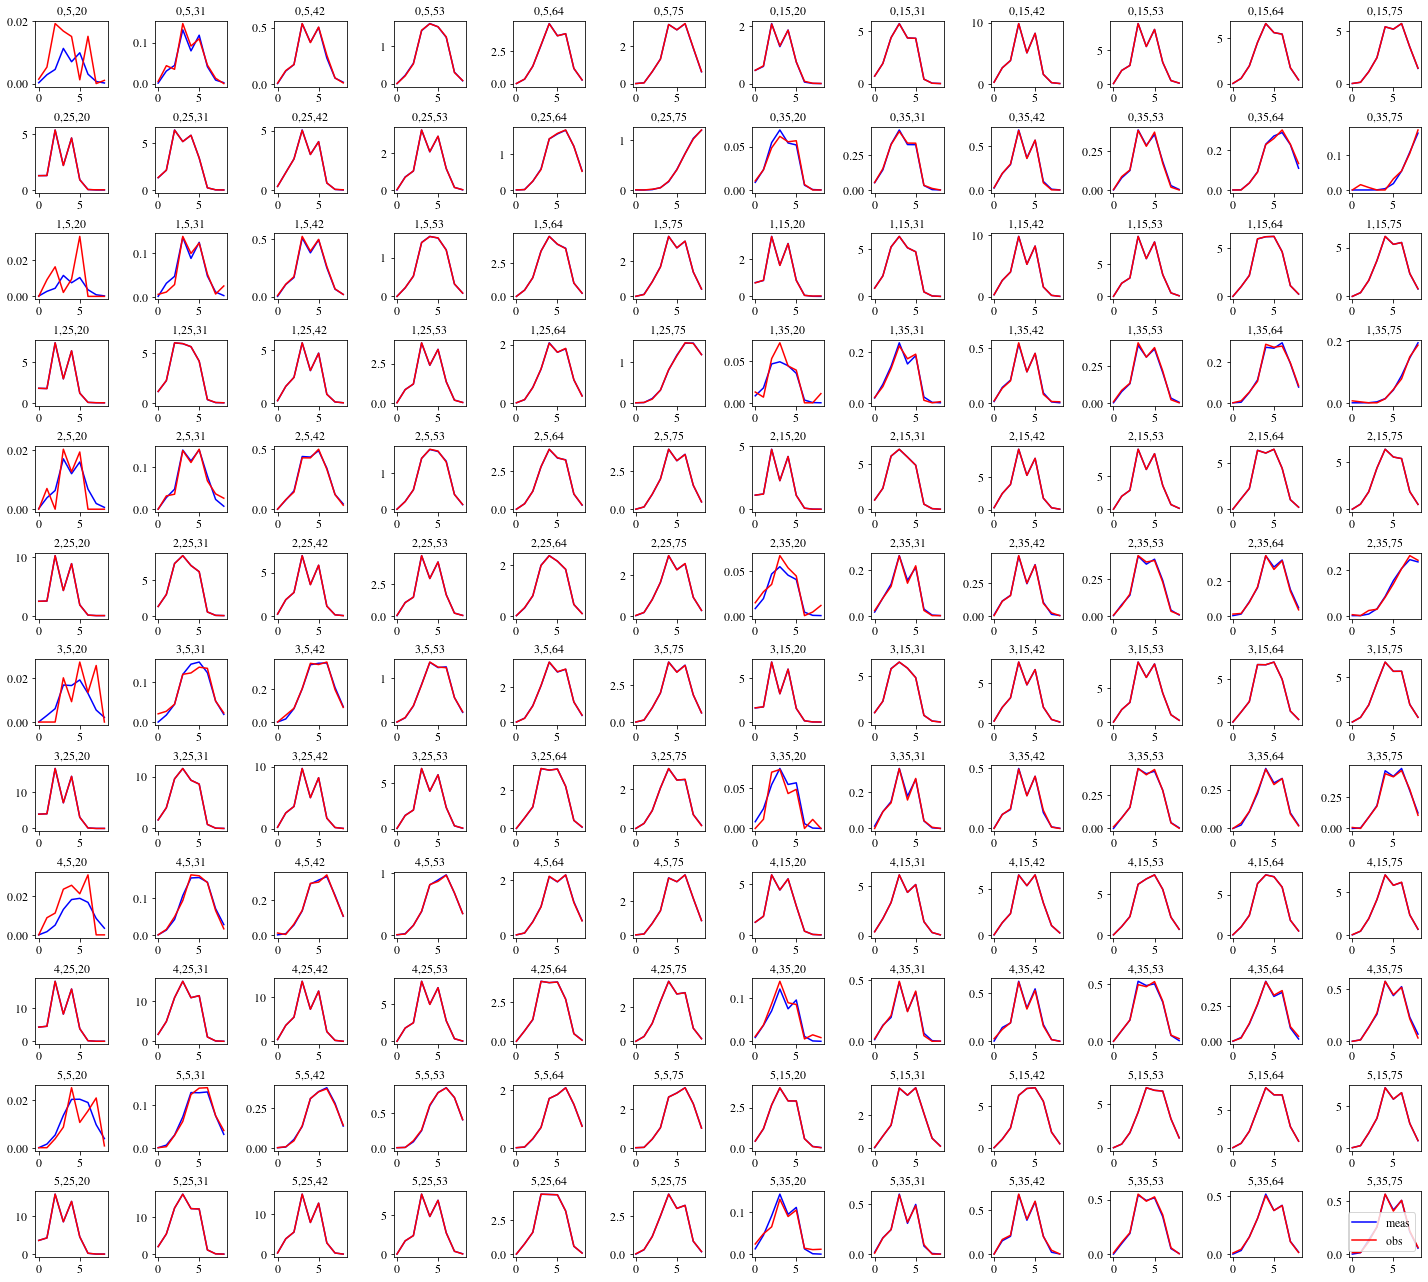

In [93]:
meas_data = meas_data.reshape((11,-1))
vis_sensors_2(obs.reshape((11,-1))[1:], meas_data.reshape((11,-1))[1:], np.where(sensor), '')

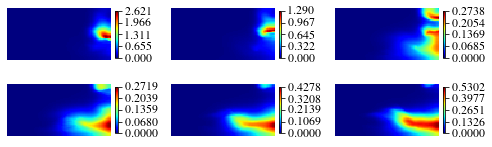

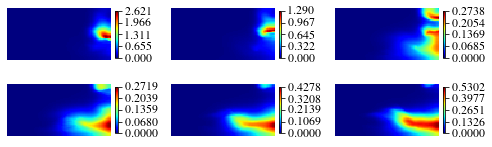

In [92]:
simple_plot(conc[-1])